In [1]:
import torch
from torchvision import models

# Load pretrained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Save the entire model to a .pt file
torch.save(model, "efficientnet_b0.pt")


/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/

In [ ]:
import torch

# Load the entire model from the .pt file
model = torch.load("efficientnet_b0.pt")

tensor(254)
pug: 0.9746
tensor(243)
bull mastiff: 0.0034
tensor(174)
Norwegian elkhound: 0.0027
tensor(262)
Brabancon griffon: 0.0012
tensor(154)
Pekinese: 0.0008


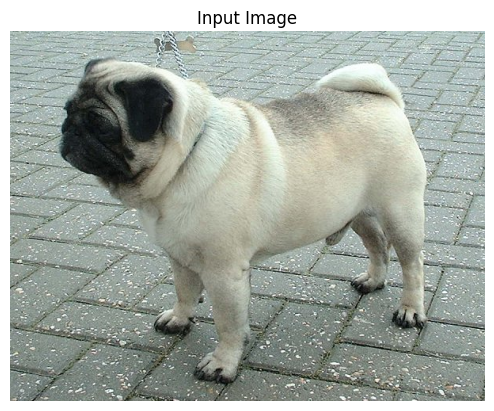

In [25]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Load a pretrained EfficientNet model
model.eval()

# Define the image transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# Download a sample image
url = "https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg"  # A dog
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

# Preprocess and prepare for model input
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # add batch dimension

# Run inference
with torch.no_grad():
    output = model(input_batch)

# Get top-5 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

# Load ImageNet labels
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.strip().split("\n")

# Print results
for i in range(top5_prob.size(0)):
    print(top5_catid[i])
    print(f"{labels[top5_catid[i]]}: {top5_prob[i].item():.4f}")

# Show the image
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()


In [9]:
import torch
from torchvision import models

# Load base model
model = torch.load("efficientnet_b0.pt")
model.eval()


# Set to eval mode
model.eval()

# Trace the model with an example input
example_input = torch.randn(1, 3, 224, 224)  # Adjust if needed
scripted_model = torch.jit.trace(model, example_input)

# Save the TorchScript model
scripted_model.save("model.pt")

# (Optional) View TorchScript graph
print(scripted_model.graph)


graph(%self.1 : __torch__.torchvision.models.efficientnet.EfficientNet,
      %x.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu)):
  %classifier : __torch__.torch.nn.modules.container.___torch_mangle_323.Sequential = prim::GetAttr[name="classifier"](%self.1)
  %avgpool : __torch__.torch.nn.modules.pooling.___torch_mangle_322.AdaptiveAvgPool2d = prim::GetAttr[name="avgpool"](%self.1)
  %features : __torch__.torch.nn.modules.container.___torch_mangle_321.Sequential = prim::GetAttr[name="features"](%self.1)
  %4890 : Tensor = prim::CallMethod[name="forward"](%features, %x.1)
  %4891 : Tensor = prim::CallMethod[name="forward"](%avgpool, %4890)
  %3576 : int = prim::Constant[value=1]() # /home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/efficientnet.py:348:0
  %3577 : int = prim::Constant[value=-1]() # /home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/efficientnet.py:348:0
  %input.42

In [33]:
import numpy as np
import tritonclient.http as httpclient

client = httpclient.InferenceServerClient(url="localhost:8000")

input_data = input_batch.numpy()

inputs = httpclient.InferInput("INPUT__0", input_data.shape, "FP32")
inputs.set_data_from_numpy(input_data)

outputs = httpclient.InferRequestedOutput("OUTPUT__0")

response = client.infer(model_name="enb0", inputs=[inputs], outputs=[outputs])

result = response.as_numpy("OUTPUT__0")
print("Result:", result)


Result: [[ 6.09213769e-01  3.03330481e-01  2.71251947e-01 -7.95648575e-01
  -2.06517458e-01  2.42453396e-01 -1.01673923e-01  8.62749964e-02
   1.03840578e+00 -1.55292571e+00  1.14252460e+00 -4.97914165e-01
   4.13812995e-02  2.08347321e-01  5.56112081e-02  5.08434057e-01
   1.45989966e+00  1.70436025e+00  4.46741760e-01  4.34637904e-01
  -6.11991957e-02  1.13429344e+00  4.51541245e-01  4.64555323e-02
   2.15890229e-01 -1.72924697e-01 -7.85611123e-02 -5.89321136e-01
  -1.20741701e+00 -1.26089275e-01  8.06787074e-01 -2.89937258e-01
  -3.36838543e-01  2.21226662e-01  1.78194866e-01 -8.10073763e-02
   8.35200429e-01 -5.51098287e-02 -5.73360682e-01  1.83741033e-01
   7.59590864e-01 -5.26873112e-01  5.21948457e-01  6.60031736e-02
   6.03030562e-01  7.56077230e-01  5.27355224e-02 -2.75520623e-01
  -1.74041778e-01 -7.55043566e-01 -1.04637003e+00 -1.25328994e+00
   6.74022064e-02  1.05346739e+00  6.73327923e-01  1.72800601e+00
   1.15344092e-01  8.51052761e-01  6.94228292e-01  4.87379313e-01
  

In [26]:
result

array([[-8.18597004e-02,  1.94272757e-01,  3.70831639e-01,
         1.77058771e-01,  5.58723390e-01,  2.31875241e-01,
         2.24985927e-02,  1.85588762e-01, -1.50593966e-02,
         2.78675973e-01,  2.83353984e-01,  1.87656194e-01,
        -1.47616029e-01,  2.55903780e-01,  6.41057789e-02,
        -9.07952040e-02, -7.63215125e-03,  2.53157794e-01,
         2.48511717e-01,  9.99330282e-02,  4.81501698e-01,
         1.03013098e+00,  1.04010212e+00,  1.33233249e-01,
         5.90080172e-02,  1.09385051e-01,  2.56805539e-01,
         1.22550249e-01,  2.20594823e-01,  1.63188651e-02,
        -3.59588638e-02, -9.08755213e-02, -6.14819229e-02,
         3.45968127e-01,  3.59107167e-01, -2.18488336e-01,
        -1.52913362e-01, -3.99299651e-01, -8.56355354e-02,
        -1.56242549e-02,  8.77053291e-02, -1.11603118e-01,
         1.89959198e-01, -2.44548082e-01, -6.73185363e-02,
        -2.17028439e-01,  2.63422072e-01, -7.04142302e-02,
        -6.69074059e-02,  2.51981467e-02,  4.76814926e-0

In [30]:
result[0].shape

(1000,)

In [34]:
data = list(result[0])
N = 5

# Sort indices based on values in descending order
sorted_indices = sorted(range(len(data)), key=lambda i: data[i], reverse=True)

# Get the top N indices
top_n_indices = sorted_indices[:N]

# print(f"Original list: {data}")
print(f"Indices of the top {N} values: {top_n_indices}")

Indices of the top 5 values: [254, 243, 174, 262, 154]


In [16]:
torch_tensor = torch.from_numpy(result)

In [19]:
probabilities = torch.nn.functional.softmax(torch_tensor, dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
top5_catid , top5_prob


(tensor([[3, 4, 1, 0, 2]]), tensor([[1., 1., 1., 1., 1.]]))

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [ ]:
# Load ImageNet labels
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.strip().split("\n")

# Print results
for i in range(top5_prob.size(0)):
    print(top5_catid[i])
    print(f"{labels[top5_catid[i]]}: {top5_prob[i].item():.4f}")


tensor([3, 4, 1, 0, 2])


TypeError: only integer tensors of a single element can be converted to an index

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum(axis=-1, keepdims=True)

probabilities = softmax(result[0])

# Step 3: Get predicted class index
predicted_class = np.argmax(probabilities, axis=-1)

print("Probabilities:", probabilities)
print("Predicted class index:", predicted_class)# Load ImageNet labels


# Print results


Probabilities: [0.00086118 0.00113505 0.00135423 0.00111568 0.00163416 0.00117854
 0.0009559  0.00112524 0.00092067 0.00123501 0.0012408  0.00112757
 0.00080637 0.00120721 0.00099652 0.00085352 0.00092753 0.0012039
 0.00119831 0.00103287 0.00151272 0.00261833 0.00264457 0.00106784
 0.00099145 0.00104268 0.00120829 0.00105649 0.00116532 0.00095002
 0.00090163 0.00085345 0.00087891 0.00132098 0.00133845 0.0007512
 0.00080211 0.00062695 0.00085793 0.00092015 0.00102031 0.00083594
 0.00113017 0.00073188 0.00087379 0.0007523  0.00121632 0.00087109
 0.00087415 0.00095849 0.00150564 0.00058863 0.00115969 0.00123886
 0.00105133 0.0013466  0.0009714  0.00092252 0.00118747 0.0017474
 0.00096135 0.00095873 0.00065044 0.00136725 0.00117576 0.00121027
 0.00082058 0.00074648 0.00087374 0.00102447 0.00078225 0.00110685
 0.00118702 0.00111268 0.00121041 0.0012594  0.00076905 0.00108377
 0.00141    0.00107189 0.00103174 0.00163791 0.00099914 0.00086914
 0.0008808  0.00116425 0.00101595 0.00116611 0.001

In [5]:
import torch
from torchvision import models

# Load base model and set to eval
model = models.efficientnet_b0(pretrained=True)
model.eval()

# Example input for tracing
example_input = torch.randn(1, 3, 224, 224)

# Convert to TorchScript
traced_model = torch.jit.trace(model, example_input)

# Save TorchScript model
traced_model.save("model.pt")


/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiongkai/anaconda3/envs/triton/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
